# Predicting Heart Disease

**Authors: Elnaz Azizi, Charly Watts, Christian Unterrainer**

## 1. Introduction & Objective

This notebook aims to predict the presence of heart disease using machine learning techniques. We will be working with subsets of the **UCI Heart Disease Dataset**, specifically the data from:
1.  Cleveland Clinic Foundation
2.  Swiss University Hospital, Basel/Zurich
3.  Hungarian Institute of Cardiology, Budapest

These datasets are commonly used benchmarks for this classification task.

**Objective:**
The primary goal is to build, evaluate, and compare several classification models:
1. Logistic Regression (Baseline)
2. K-Nearest Neighbors (KNN) (Baseline)
3. Gaussian Naive Bayes (Baseline)
4. Gradient Boosting Classifier
5. MLP Classifier (Neural Network)
6. Random Forest Classifier
7. Support Vector Machine (SVM) Classifier

We will employ appropriate data preprocessing steps, including imputation and scaling. Model evaluation will focus on the F1-score for the positive class (presence of heart disease). Two main evaluation strategies will be explored:
- **Nested Cross-Validation:** To obtain a robust estimate of model generalization performance.
- **Train/Test Split with GridSearchCV & Threshold Optimization:** To identify a specific "best" model configuration and optimize its decision threshold for the F1-score.

The notebook will walk through data loading, preprocessing, model pipeline definition, evaluation, and visualization of the results.

## 2. Imports

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, f1_score
from IPython.display import display # For better table rendering

## 3. Data Loading and Initial Preparation

### 3.1. Load Data from Files
We load three processed datasets originating from the UCI Heart Disease repository: Cleveland, Switzerland, and Hungarian. Missing values are denoted by '?' in the raw files. The Hungarian dataset is space-separated, while the others are comma-separated.

In [25]:
# List of tuples: (filepath, is_space_separated)
file_info = [
    ('data/processed.cleveland.data', False),
    ('data/processed.switzerland.data', False),
    ('data/reprocessed.hungarian.data', True),  # space-separated
]

# Column names for the dataset(s); assumed to be the same across all files
col_names = [
    'age','sex','cp','trestbps','chol','fbs',
    'restecg','thalach','exang','oldpeak',
    'slope','ca','thal','target'
]

dataframes = []
df_names = ['Cleveland', 'Switzerland', 'Hungarian'] 

for path, is_space_separated in file_info:
    if is_space_separated:
        df = pd.read_csv(path, sep=r'\s+', header=None, names=col_names, na_values='?')
    else:
        df = pd.read_csv(path, header=None, names=col_names, na_values='?')
    dataframes.append(df)

### 3.2. Initial Data Inspection (Brief)
A quick check for data types and missing values.

In [26]:
for df_name, df in zip(df_names, dataframes):
    print(f"\n--- {df_name} Dataset Info ---")
    df.info()
    print(f"\n--- Missing Values in {df_name} (Count) ---")
    print(df.isnull().sum())


--- Cleveland Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB

--- Missing Values in Cleveland (Count) ---
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
sl

## 4. Data Preparation for Modeling

### 4.1. Target Variable Transformation and Train-Test Split
The target variable is binarized (0: no disease, 1: presence of disease). Data is then split into stratified training and testing sets.

In [27]:
splits = []

for df, (path, _) in zip(dataframes, file_info):
    dataset_name_from_path = path.split('/')[-1] 
    df['target'] = df['target'].astype(int).apply(lambda v: 1 if v > 0 else 0)
    x = df.drop(columns='target')
    y = df['target']
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y 
    )
    splits.append({
        "dataset": dataset_name_from_path,
        "x_train": x_train, "x_test": x_test,
        "y_train": y_train, "y_test": y_test
    })
    print(f"\n--- Target distribution in {dataset_name_from_path} (Binarized) ---")
    print(f"Original: {y.value_counts(normalize=True).sort_index().to_dict()}")
    print(f"Train:    {y_train.value_counts(normalize=True).sort_index().to_dict()}")
    print(f"Test:     {y_test.value_counts(normalize=True).sort_index().to_dict()}")


--- Target distribution in processed.cleveland.data (Binarized) ---
Original: {0: 0.5412541254125413, 1: 0.45874587458745875}
Train:    {0: 0.5413223140495868, 1: 0.45867768595041325}
Test:     {0: 0.5409836065573771, 1: 0.45901639344262296}

--- Target distribution in processed.switzerland.data (Binarized) ---
Original: {0: 0.06504065040650407, 1: 0.9349593495934959}
Train:    {0: 0.061224489795918366, 1: 0.9387755102040817}
Test:     {0: 0.08, 1: 0.92}

--- Target distribution in reprocessed.hungarian.data (Binarized) ---
Original: {0: 0.6394557823129252, 1: 0.36054421768707484}
Train:    {0: 0.6382978723404256, 1: 0.3617021276595745}
Test:     {0: 0.6440677966101694, 1: 0.3559322033898305}


### 4.2. Feature Column Configuration

In [28]:
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

### 4.3. Preprocessing Pipeline Definition
Numeric features are imputed with the median and scaled. Categorical features are imputed with the most frequent value, and an indicator for imputation is added.

In [29]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True))
])
preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_cols),
    ('cat', cat_pipe, categorical_cols)
])

## 5. Modeling Pipeline Definition

### 5.1. Full Model Pipelines
Pipelines are defined for each classifier, integrating the preprocessor. `random_state` is set for reproducibility where applicable.

In [30]:
logistic_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42)) 
])
kneighbors_pipeline = Pipeline([
    ('pre', preprocessor),
    ('knn', KNeighborsClassifier())
])
naive_pipeline = Pipeline([
    ('pre', preprocessor),
    ('nav', GaussianNB())
])
gradient_boosting_pipeline = Pipeline([
    ('pre', preprocessor),
    ('gbc', GradientBoostingClassifier(random_state=42))
])
mlp_pipeline = Pipeline([
    ('pre', preprocessor),
    ('mlp', MLPClassifier(random_state=42, max_iter=1000)) 
])
rf_pipeline = Pipeline([
    ('pre', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])
svm_pipeline = Pipeline([
    ('pre', preprocessor),
    ('svc', SVC(random_state=42, probability=True))
])

### 5.2. Hyperparameter Grids
Hyperparameter search spaces are defined for each model (except Naive Bayes). Grids are kept relatively small for manageable runtimes.

In [31]:
logistic_param_grid = {
    'clf__C': [0.01, 0.1, 1, 10]  # Inverse of regularization strength; smaller values specify stronger regularization.
}
kneighbors_param_grid = {
    'knn__n_neighbors': list(range(1, 21))  # Number of neighbors to use.
}
naive_param_grid = {}  # No significant hyperparameters for GaussianNB to tune in this context.

gradient_boosting_param_grid = {
    'gbc__n_estimators': [100, 200],        # Number of boosting stages (trees) to run.
    'gbc__learning_rate': [0.05, 0.1],     # Step size shrinkage used in update to prevent overfitting.
    'gbc__max_depth': [3, 5],                  # Maximum depth of the individual regression estimators (trees).
    'gbc__subsample': [0.8],                 # Fraction of samples to be used for fitting individual base learners.
    'gbc__min_samples_split': [5],         # Minimum number of samples required to split an internal node.
    'gbc__min_samples_leaf': [3]           # Minimum number of samples required to be at a leaf node.
}

mlp_param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100, 50)], # Tuple, ith element is number of neurons in ith hidden layer.
    'mlp__activation': ['relu'],                   # Activation function for the hidden layer ('relu', 'tanh', 'logistic').
    'mlp__solver': ['adam'],                       # The solver for weight optimization ('adam', 'sgd', 'lbfgs').
    'mlp__alpha': [0.001, 0.01],                   # L2 penalty (regularization term) parameter.
    'mlp__learning_rate_init': [0.001],            # The initial learning rate used.
    'mlp__early_stopping': [True],                 # Whether to use early stopping to terminate training when validation score is not improving.
    'mlp__n_iter_no_change': [10]                  # Number of iterations with no improvement to wait before stopping.
}

rf_param_grid = {
    'rf__n_estimators' : [100, 200],              # The number of trees in the forest.
    'rf__max_depth' : [None, 10, 20],             # The maximum depth of the tree. If None, nodes expanded until all leaves are pure or contain less than min_samples_split.
    'rf__min_samples_split' : [2, 5],             # The minimum number of samples required to split an internal node.
    'rf__min_samples_leaf' : [1, 2],              # The minimum number of samples required to be at a leaf node.
    'rf__class_weight': ['balanced', None]         # Weights associated with classes ('balanced', 'balanced_subsample', or None).
}

svm_param_grid = {
    'svc__C': [0.1, 1, 10],                       # Regularization parameter. Strength is inversely proportional to C.
    'svc__kernel': ['linear', 'rbf'],              # Specifies the kernel type to be used in the algorithm ('linear', 'poly', 'rbf', 'sigmoid').
    'svc__gamma': ['scale', 'auto', 0.1]           # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'. 'scale' and 'auto' are good defaults.
}

### 5.3. Model Configurations Dictionary
A dictionary mapping model names to their pipelines and hyperparameter grids for streamlined evaluation.

In [32]:
model_configurations = {
    "Logistic Regression": (logistic_pipeline, logistic_param_grid),
    "K Nearest Neighbors": (kneighbors_pipeline, kneighbors_param_grid),
    "Naive Bayes": (naive_pipeline, naive_param_grid),
    "Gradient Boosting": (gradient_boosting_pipeline, gradient_boosting_param_grid),
    "MLP Classifier": (mlp_pipeline, mlp_param_grid),
    "Random Forest": (rf_pipeline, rf_param_grid),
    "SVM Classifier": (svm_pipeline, svm_param_grid)
}

## 6. Model Evaluation Strategies

### 6.1. Nested Cross-Validation for Robust Performance Estimation
Nested CV provides a less biased estimate of model generalization performance. The outer loop evaluates, while the inner loop tunes hyperparameters. F1-score is the primary metric.

In [33]:
nested_cv_results_summary = []

for split_data in splits: 
    dataset_name = split_data["dataset"]
    # print(f"Running Nested CV for dataset: {dataset_name}") # Removed for cleaner output

    X_full = pd.concat([split_data["x_train"], split_data["x_test"]], ignore_index=True)
    y_full = pd.concat([split_data["y_train"], split_data["y_test"]], ignore_index=True)

    for model_name, (pipeline, param_grid) in model_configurations.items():
        # print(f"  Model: {model_name}") # Removed for cleaner output
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) 
        grid_search_cv = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='f1', n_jobs=-1)
        outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
        nested_f1_scores = cross_val_score(grid_search_cv, X_full, y_full, cv=outer_cv, scoring='f1', n_jobs=-1)

        nested_cv_results_summary.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Nested F1 Mean": nested_f1_scores.mean(),
            "Nested F1 Std": nested_f1_scores.std()
        })

nested_cv_df = pd.DataFrame(nested_cv_results_summary)
print("\n--- Nested Cross-Validation Results Summary ---")
display(nested_cv_df.round(3))


--- Nested Cross-Validation Results Summary ---


,Dataset,Model,Nested F1 Mean,Nested F1 Std
0,processed.cleveland.data,Logistic Regression,0.778,0.043
1,processed.cleveland.data,K Nearest Neighbors,0.768,0.041
2,processed.cleveland.data,Naive Bayes,0.700,0.133
3,processed.cleveland.data,Gradient Boosting,0.758,0.047
4,processed.cleveland.data,MLP Classifier,0.689,0.096
5,processed.cleveland.data,Random Forest,0.787,0.028
6,processed.cleveland.data,SVM Classifier,0.788,0.040
7,processed.switzerland.data,Logistic Regression,0.966,0.010
8,processed.switzerland.data,K Nearest Neighbors,0.966,0.010
9,processed.switzerland.data,Naive Bayes,0.665,0.100


### 6.2. Train/Test Split with GridSearchCV & Threshold Optimization
This approach tunes hyperparameters on the training set (optimizing for 'recall' in GridSearchCV), predicts probabilities on the test set, and then optimizes the decision threshold to maximize F1-score on the test set.

In [34]:
detailed_classic_results = [] # Renamed from 'classic_results' for clarity

for split_data in splits:
    dataset_name = split_data["dataset"]
    x_train = split_data["x_train"]
    y_train = split_data["y_train"]
    x_test = split_data["x_test"]
    y_test = split_data["y_test"]
    # print(f"\nRunning Threshold Optimization for dataset: {dataset_name}") # Removed for cleaner output

    for model_name, (pipeline, param_grid) in model_configurations.items():
        # print(f"  Model: {model_name}") # Removed for cleaner output
        grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='recall', n_jobs=-1) # cv=3 for speed
        grid.fit(x_train, y_train)

        y_probs = grid.predict_proba(x_test)[:, 1]

        precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_probs)
        f1_scores_pr = 2 * (precisions * recalls) / (precisions + recalls + 1e-10) 
        
        if len(f1_scores_pr) > len(thresholds_pr):
             best_idx_pr = np.argmax(f1_scores_pr[:-1]) 
        else:
             best_idx_pr = np.argmax(f1_scores_pr)
        
        best_threshold = thresholds_pr[best_idx_pr]
        
        y_pred = (y_probs >= best_threshold).astype(int)

        report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        cm = confusion_matrix(y_test, y_pred)

        detailed_classic_results.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Best Estimator": grid.best_estimator_,
            "Best Params (from GridSearchCV)": grid.best_params_,
            "Optimized Threshold": best_threshold,
            "Recall (Class 1, Opt Thresh)": report_dict.get('1', {}).get('recall', 0),
            "Precision (Class 1, Opt Thresh)": report_dict.get('1', {}).get('precision', 0),
            "F1-Score (Class 1, Opt Thresh)": report_dict.get('1', {}).get('f1-score', 0),
            "Confusion Matrix": cm,
            "y_test": y_test,
            "y_probs": y_probs,
            "y_pred_optimized_thresh": y_pred,
            "precisions_pr": precisions, 
            "recalls_pr": recalls,       
            "f1_scores_pr": f1_scores_pr 
        })

threshold_optimization_summary_list = []
for res in detailed_classic_results:
    threshold_optimization_summary_list.append({
        "Dataset": res["Dataset"],
        "Model": res["Model"],
        "F1-Score (Optimized Threshold)": res["F1-Score (Class 1, Opt Thresh)"],
        "Optimized Threshold": res["Optimized Threshold"],
    })
threshold_optimization_df_summary = pd.DataFrame(threshold_optimization_summary_list)

print("\n--- Threshold Optimization Results Summary ---")
display(threshold_optimization_df_summary.pivot_table(
    index=['Dataset', 'Model'], 
    values=['F1-Score (Optimized Threshold)', 'Optimized Threshold']
).round(3))


--- Threshold Optimization Results Summary ---


F1-Score (Optimized Threshold)  \
Dataset                    Model                                                 
processed.cleveland.data   Gradient Boosting                             0.926   
                           K Nearest Neighbors                           0.759   
                           Logistic Regression                           0.909   
                           MLP Classifier                                0.629   
                           Naive Bayes                                   0.844   
                           Random Forest                                 0.900   
                           SVM Classifier                                0.852   
processed.switzerland.data Gradient Boosting                             0.958   
                           K Nearest Neighbors                           0.958   
                           Logistic Regression                           0.958   
                           MLP Classifier                                0.958   
                           Naive Bayes                                   0.958   
                           Random Forest                                 0.958   
                           SVM Classifier                                0.958   
reprocessed.hungarian.data Gradient Boosting                             0.769   
                           K Nearest Neighbors                           0.810   
                           Logistic Regression                           0.850   
                           MLP Classifier                                0.857   
                           Naive Bayes                                   0.818   
                           Random Forest                                 0.811   
                           SVM Classifier                                0.717   

                                                Optimized Threshold  
Dataset                    Model                                     
processed.cleveland.data   Gradient Boosting                  0.809  
                           K Nearest Neighbors                0.667  
                           Logistic Regression                0.652  
                           MLP Classifier                     0.288  
                           Naive Bayes                        0.000  
                           Random Forest                      0.480  
                           SVM Classifier                     0.535  
processed.switzerland.data Gradient Boosting                  0.005  
                           K Nearest Neighbors                0.600  
                           Logistic Regression                0.931  
                           MLP Classifier                     0.526  
                           Naive Bayes                        0.000  
                           Random Forest                      0.560  
                           SVM Classifier                     0.926  
reprocessed.hungarian.data Gradient Boosting                  0.598  
                           K Nearest Neighbors                0.600  
                           Logistic Regression                0.464  
                           MLP Classifier                     0.441  
                           Naive Bayes                        0.287  
                           Random Forest                      0.645  
                           SVM Classifier                     0.217

## 7. Results Visualization and Comparison

### 7.1. Tabular F1-Score Comparison (All Models - Nested CV vs. Threshold Optimization)

In [35]:
thresh_opt_df_for_plot = pd.DataFrame([{
    "Dataset": res["Dataset"], 
    "Model": res["Model"], 
    "F1-Score": res["F1-Score (Class 1, Opt Thresh)"]} 
    for res in detailed_classic_results])
thresh_opt_df_for_plot["Type"] = "Threshold Optimization"

nested_df_for_plot = nested_cv_df.copy()
nested_df_for_plot.rename(columns={"Nested F1 Mean": "F1-Score"}, inplace=True)
nested_df_for_plot["Type"] = "Nested CV"

combined_f1_df_for_comparison = pd.concat([
    thresh_opt_df_for_plot[["Dataset", "Model", "F1-Score", "Type"]],
    nested_df_for_plot[["Dataset", "Model", "F1-Score", "Type"]]
], ignore_index=True)

print("\n--- F1 Score Comparison: Nested CV vs. Threshold Optimization (All Models) ---")
pivot_table_f1_all_models = combined_f1_df_for_comparison.pivot_table(
    index=["Dataset", "Model"], 
    columns="Type", 
    values="F1-Score"
).round(3)
display(pivot_table_f1_all_models)


--- F1 Score Comparison: Nested CV vs. Threshold Optimization (All Models) ---


Type                                            Nested CV  \
Dataset                    Model                            
processed.cleveland.data   Gradient Boosting        0.758   
                           K Nearest Neighbors      0.768   
                           Logistic Regression      0.778   
                           MLP Classifier           0.689   
                           Naive Bayes              0.700   
                           Random Forest            0.787   
                           SVM Classifier           0.788   
processed.switzerland.data Gradient Boosting        0.949   
                           K Nearest Neighbors      0.966   
                           Logistic Regression      0.966   
                           MLP Classifier           0.953   
                           Naive Bayes              0.665   
                           Random Forest            0.958   
                           SVM Classifier           0.966   
reprocessed.hungarian.data Gradient Boosting        0.693   
                           K Nearest Neighbors      0.719   
                           Logistic Regression      0.743   
                           MLP Classifier           0.688   
                           Naive Bayes              0.679   
                           Random Forest            0.725   
                           SVM Classifier           0.741   

Type                                            Threshold Optimization  
Dataset                    Model                                        
processed.cleveland.data   Gradient Boosting                     0.926  
                           K Nearest Neighbors                   0.759  
                           Logistic Regression                   0.909  
                           MLP Classifier                        0.629  
                           Naive Bayes                           0.844  
                           Random Forest                         0.900  
                           SVM Classifier                        0.852  
processed.switzerland.data Gradient Boosting                     0.958  
                           K Nearest Neighbors                   0.958  
                           Logistic Regression                   0.958  
                           MLP Classifier                        0.958  
                           Naive Bayes                           0.958  
                           Random Forest                         0.958  
                           SVM Classifier                        0.958  
reprocessed.hungarian.data Gradient Boosting                     0.769  
                           K Nearest Neighbors                   0.810  
                           Logistic Regression                   0.850  
                           MLP Classifier                        0.857  
                           Naive Bayes                           0.818  
                           Random Forest                         0.811  
                           SVM Classifier                        0.717

### 7.1.1. Identifying the Best Performing Baseline Model
We select the best baseline (Logistic Regression, KNN, Naive Bayes) by considering both its robust Nested CV F1 Mean and its performance in the Threshold Optimization approach. This chosen baseline will be used for focused comparison against advanced models.

In [36]:
baseline_model_names = ["Logistic Regression", "K Nearest Neighbors", "Naive Bayes"]
advanced_model_names = ["Gradient Boosting", "MLP Classifier", "Random Forest", "SVM Classifier"]

# --- 1. Analysis based on Nested CV F1 Mean for Baselines ---
baseline_nested_cv_results_df = nested_cv_df[nested_cv_df['Model'].isin(baseline_model_names)]
print("\n--- Performance of Baseline Models (Nested CV F1 Mean) ---")
baseline_pivot_nested = baseline_nested_cv_results_df.pivot_table(
    index="Dataset", columns="Model", values="Nested F1 Mean"
).round(3)
display(baseline_pivot_nested)
print("-" * 70)

avg_nested_f1_baselines = baseline_nested_cv_results_df.groupby('Model')['Nested F1 Mean'].mean().sort_values(ascending=False).round(3)
print("\n--- Average Nested F1 Means for Baseline Models (Ranked) ---")
if len(avg_nested_f1_baselines) <= 3:
    print(avg_nested_f1_baselines.to_string())
else:
    display(avg_nested_f1_baselines.to_frame())
print("-" * 70)

# --- 2. Analysis based on Threshold Optimization F1-Score for Baselines ---
thresh_opt_f1_scores_baselines_list = []
for res_item in detailed_classic_results: # Using detailed_classic_results as it has the Opt Thresh F1
    if res_item['Model'] in baseline_model_names:
        thresh_opt_f1_scores_baselines_list.append({
            "Dataset": res_item["Dataset"],
            "Model": res_item["Model"],
            "F1-Score (Optimized Threshold)": res_item["F1-Score (Class 1, Opt Thresh)"] 
        })
baseline_thresh_opt_results_df = pd.DataFrame(thresh_opt_f1_scores_baselines_list)

if not baseline_thresh_opt_results_df.empty:
    print("\n\n--- Performance of Baseline Models (Threshold Optimization F1-Score) ---")
    baseline_pivot_thresh_opt = baseline_thresh_opt_results_df.pivot_table(
        index="Dataset", columns="Model", values="F1-Score (Optimized Threshold)"
    ).round(3)
    display(baseline_pivot_thresh_opt)
    print("-" * 70)

    avg_thresh_opt_f1_baselines = baseline_thresh_opt_results_df.groupby('Model')['F1-Score (Optimized Threshold)'].mean().sort_values(ascending=False).round(3)
    print("\n--- Average Threshold Optimization F1 Scores for Baseline Models (Ranked) ---")
    if len(avg_thresh_opt_f1_baselines) <=3:
        print(avg_thresh_opt_f1_baselines.to_string())
    else:
        display(avg_thresh_opt_f1_baselines.to_frame())
    print("-" * 70)
else:
    print("\nNo baseline model results found in 'detailed_classic_results' for Threshold Optimization F1 analysis.")
    avg_thresh_opt_f1_baselines = pd.Series(dtype='float64')

# --- 3. Decision for 'overall_best_baseline_name' for subsequent plots ---
overall_best_baseline_name = None
if not avg_nested_f1_baselines.empty:
    overall_best_baseline_name = avg_nested_f1_baselines.idxmax()
    best_nested_f1_score = avg_nested_f1_baselines.max()
    best_thresh_opt_f1_score = None
    if overall_best_baseline_name in avg_thresh_opt_f1_baselines.index:
        best_thresh_opt_f1_score = avg_thresh_opt_f1_baselines[overall_best_baseline_name]
    print(f"\n>>> Decision: Selected '{overall_best_baseline_name}' as the Best Baseline for focused plots. <<<")
    print(f"    Reason: Highest average Nested CV F1 Mean ({best_nested_f1_score:.3f}).")
    if best_thresh_opt_f1_score is not None:
        print(f"    Its average Threshold Optimization F1-Score is: {best_thresh_opt_f1_score:.3f}.")
else:
    print("\n>>> Warning: Could not determine an overall best baseline model from Nested CV results. <<<")

if overall_best_baseline_name:
    models_for_focused_plots = [overall_best_baseline_name] + advanced_model_names
else:
    print("Warning: No best baseline selected. Focused plots will show advanced models only.")
    models_for_focused_plots = advanced_model_names


--- Performance of Baseline Models (Nested CV F1 Mean) ---


Model,K Nearest Neighbors,Logistic Regression,Naive Bayes
Dataset,,,
processed.cleveland.data,0.768,0.778,0.700
processed.switzerland.data,0.966,0.966,0.665
reprocessed.hungarian.data,0.719,0.743,0.679


----------------------------------------------------------------------

--- Average Nested F1 Means for Baseline Models (Ranked) ---
Model
Logistic Regression    0.829
K Nearest Neighbors    0.818
Naive Bayes            0.681
----------------------------------------------------------------------


--- Performance of Baseline Models (Threshold Optimization F1-Score) ---


Model,K Nearest Neighbors,Logistic Regression,Naive Bayes
Dataset,,,
processed.cleveland.data,0.759,0.909,0.844
processed.switzerland.data,0.958,0.958,0.958
reprocessed.hungarian.data,0.810,0.850,0.818


----------------------------------------------------------------------

--- Average Threshold Optimization F1 Scores for Baseline Models (Ranked) ---
Model
Logistic Regression    0.906
Naive Bayes            0.873
K Nearest Neighbors    0.842
----------------------------------------------------------------------

>>> Decision: Selected 'Logistic Regression' as the Best Baseline for focused plots. <<<
    Reason: Highest average Nested CV F1 Mean (0.829).
    Its average Threshold Optimization F1-Score is: 0.906.


### 7.2. Focused Visualizations: Best Baseline vs. Advanced Models
Visualizations focus on comparing the chosen best baseline against advanced models using results from the Threshold Optimization approach.

#### 7.2.1. Confusion Matrices (Best Baseline vs. Advanced)

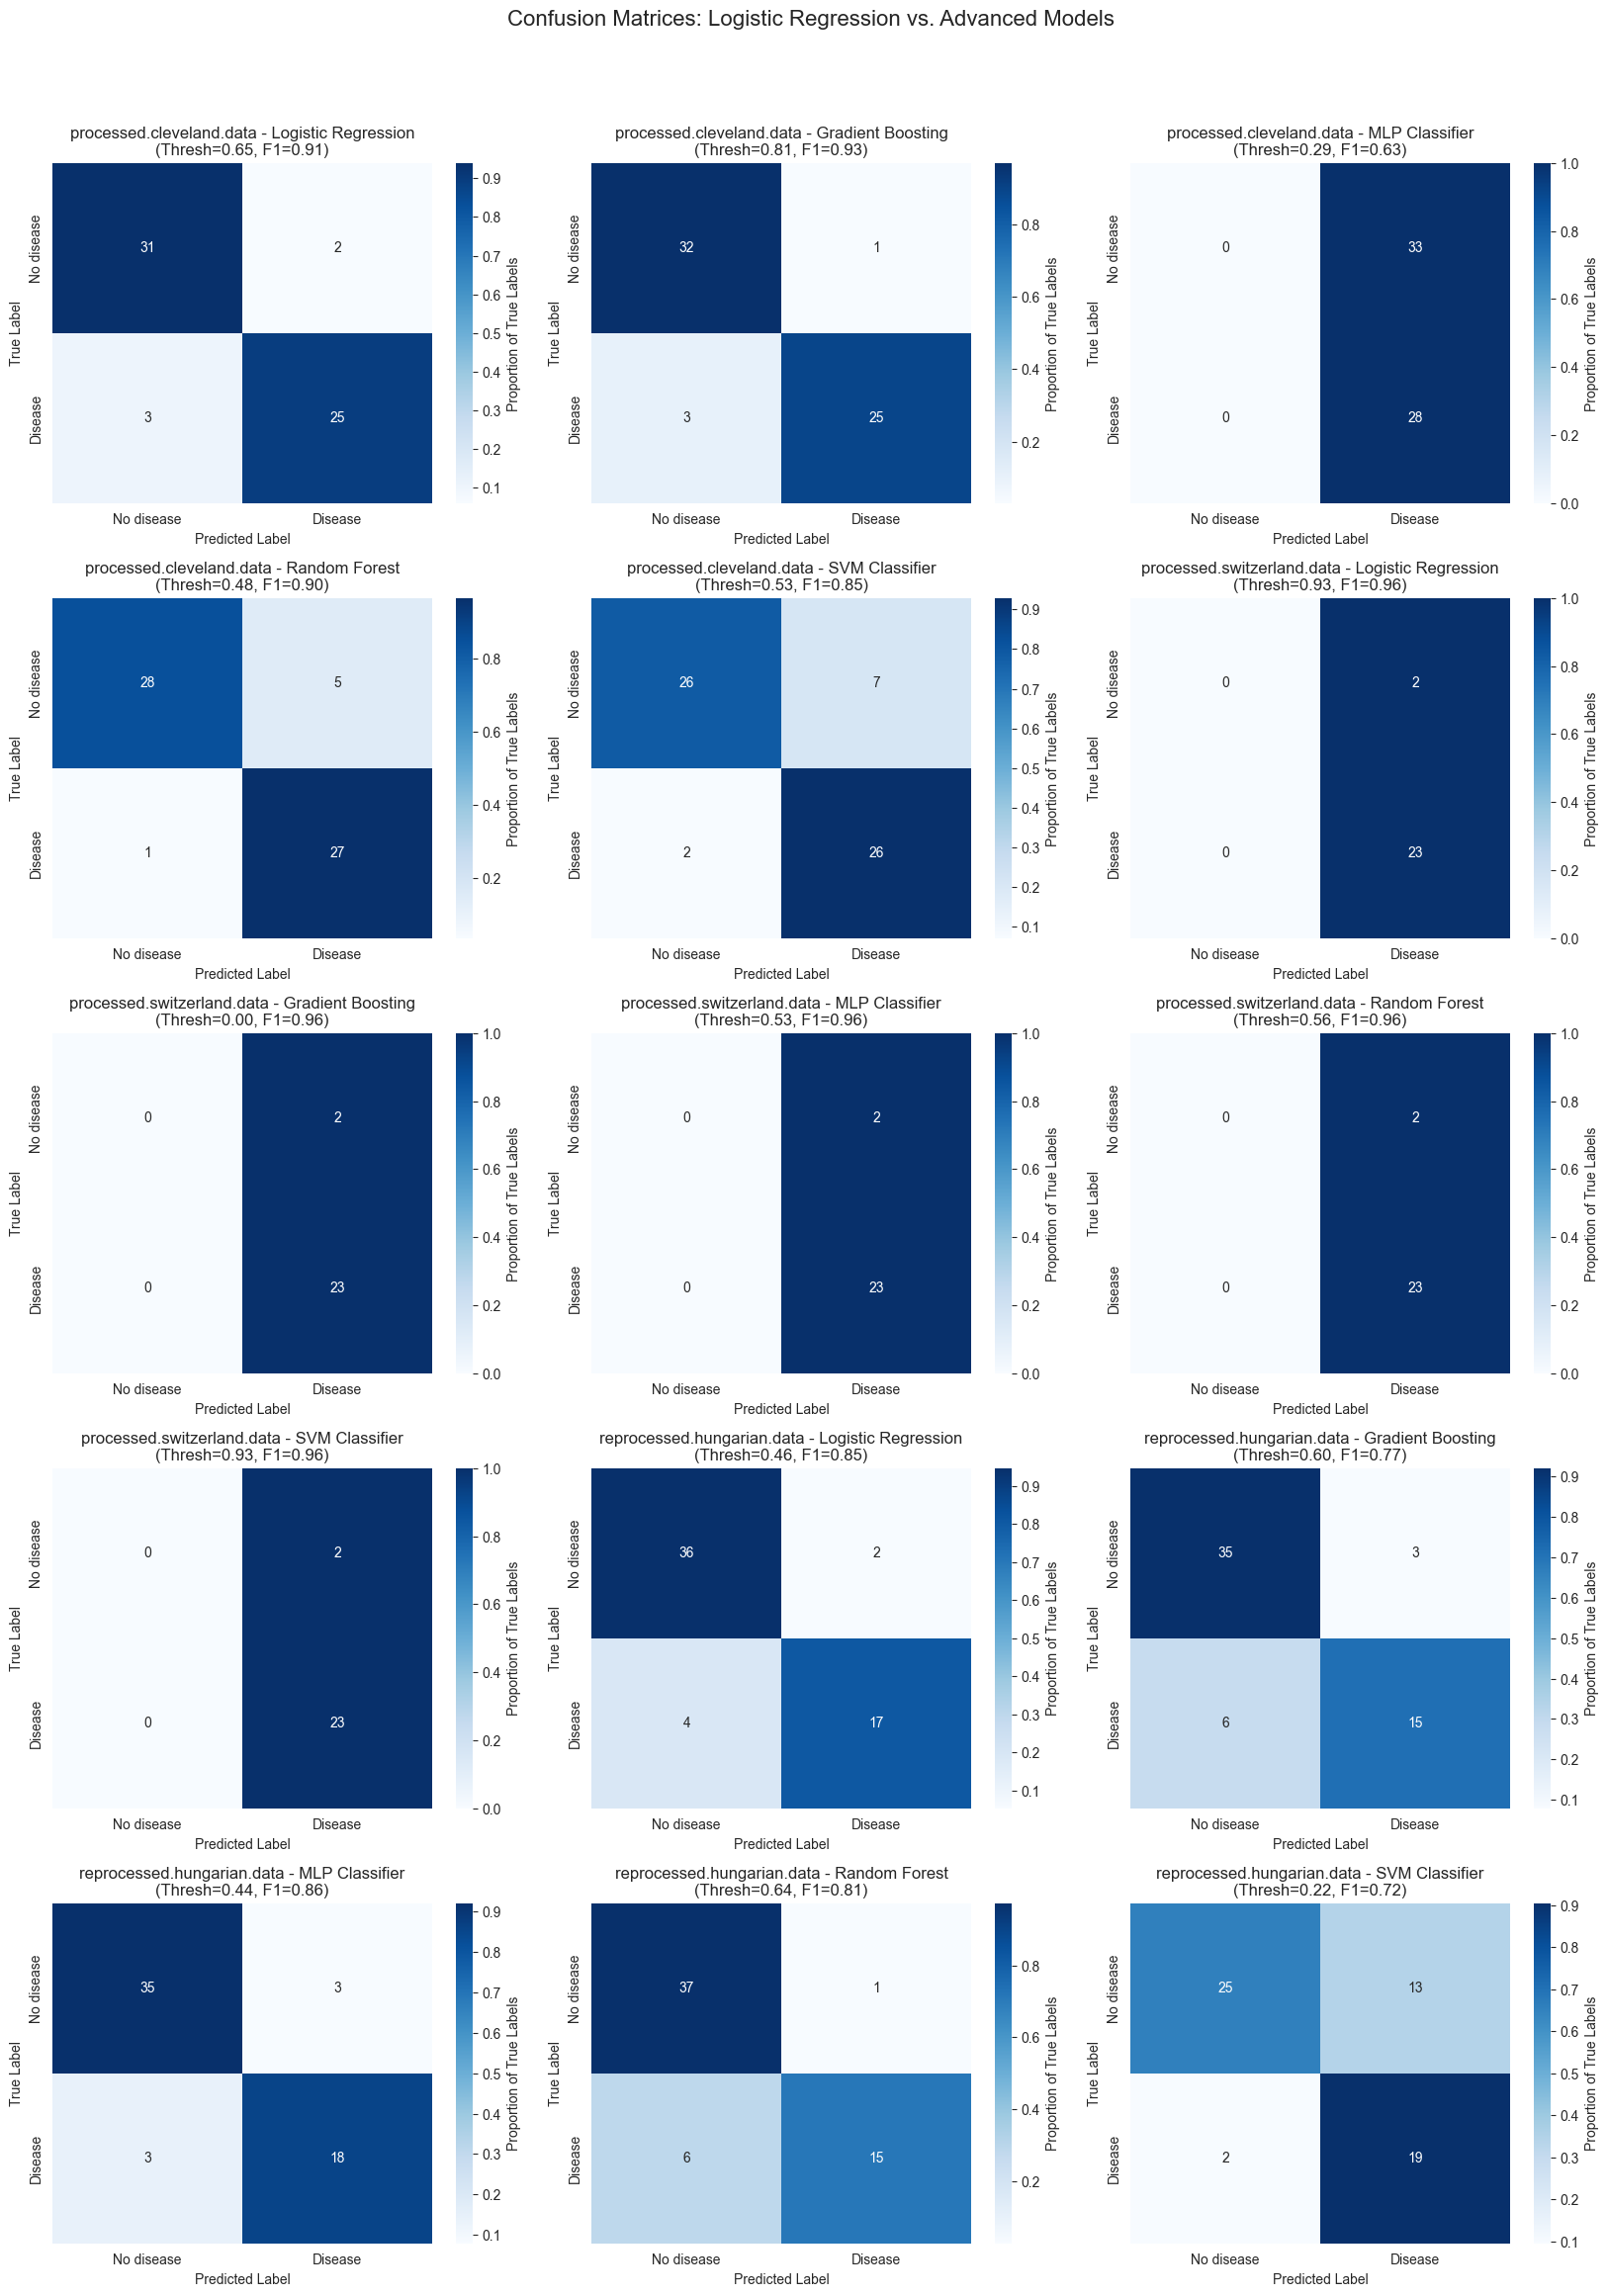

In [37]:
focused_detailed_classic_results_cm = [
    res for res in detailed_classic_results if res['Model'] in models_for_focused_plots
]
num_plots_focused_cm = len(focused_detailed_classic_results_cm)
cols_focused_cm = 3 
rows_focused_cm = math.ceil(num_plots_focused_cm / cols_focused_cm)

fig_focused_cm, axes_focused_cm = plt.subplots(rows_focused_cm, cols_focused_cm, 
                                               figsize=(cols_focused_cm * 5.5, rows_focused_cm * 4.5))
if num_plots_focused_cm == 1:
    axes_flat_focused_cm = [axes_focused_cm]
elif num_plots_focused_cm == 0:
    axes_flat_focused_cm = []
else:
    axes_flat_focused_cm = axes_focused_cm.flatten()

for idx, res in enumerate(focused_detailed_classic_results_cm):
    ax = axes_flat_focused_cm[idx]
    cm = res["Confusion Matrix"]
    cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] 
    cm_norm = np.nan_to_num(cm_norm) 
    sns.heatmap(
        cm_norm, annot=cm, fmt='d', cmap='Blues',
        xticklabels=['No disease', 'Disease'], yticklabels=['No disease', 'Disease'],
        ax=ax, cbar=True, cbar_kws={'label': 'Proportion of True Labels'}
    )
    ax.set_title(f'{res["Dataset"]} - {res["Model"]}\n(Thresh={res["Optimized Threshold"]:.2f}, F1={res["F1-Score (Class 1, Opt Thresh)"]:.2f})')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

for i in range(num_plots_focused_cm, rows_focused_cm * cols_focused_cm):
    if num_plots_focused_cm > 0 and rows_focused_cm * cols_focused_cm > 0 : 
      fig_focused_cm.delaxes(axes_flat_focused_cm[i])

title_cm = 'Confusion Matrices: Advanced Models' # Default title
if overall_best_baseline_name:
    title_cm = f'Confusion Matrices: {overall_best_baseline_name} vs. Advanced Models'
plt.suptitle(title_cm, fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

#### 7.2.2. Precision-Recall (P-R) Curves (Best Baseline vs. Advanced)

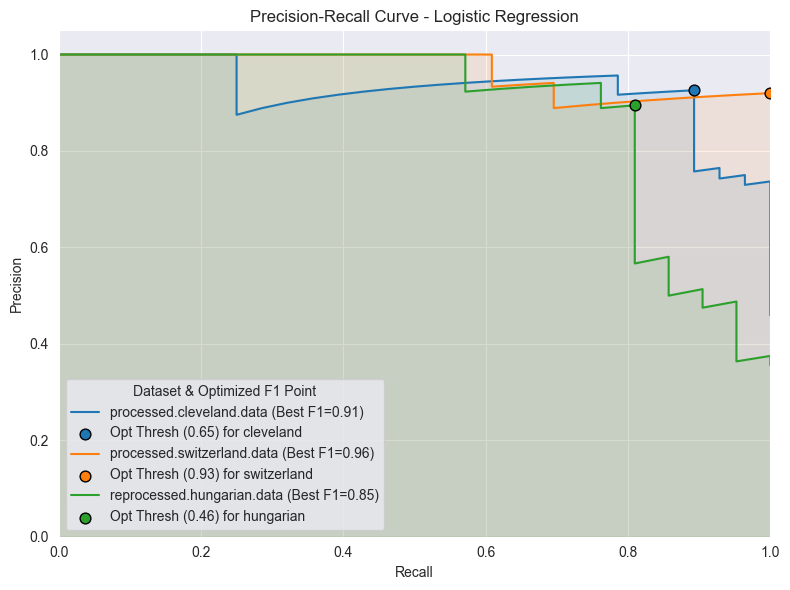

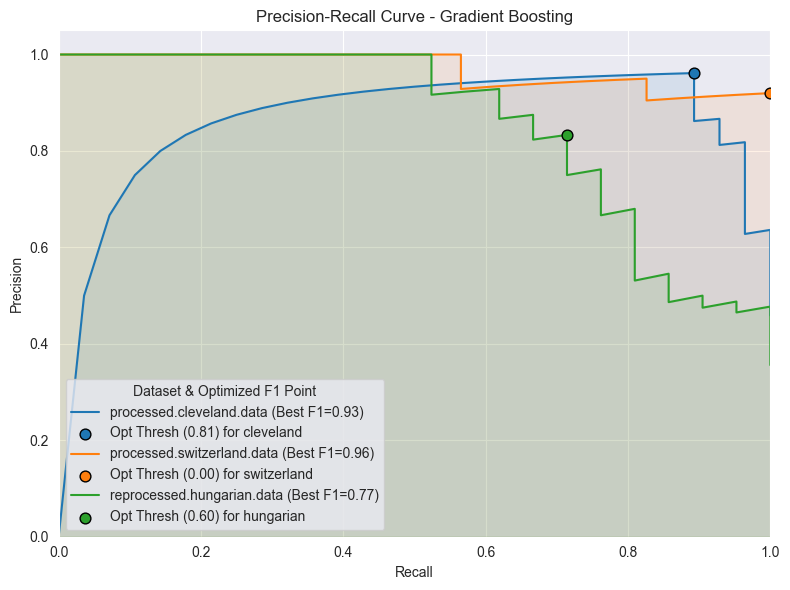

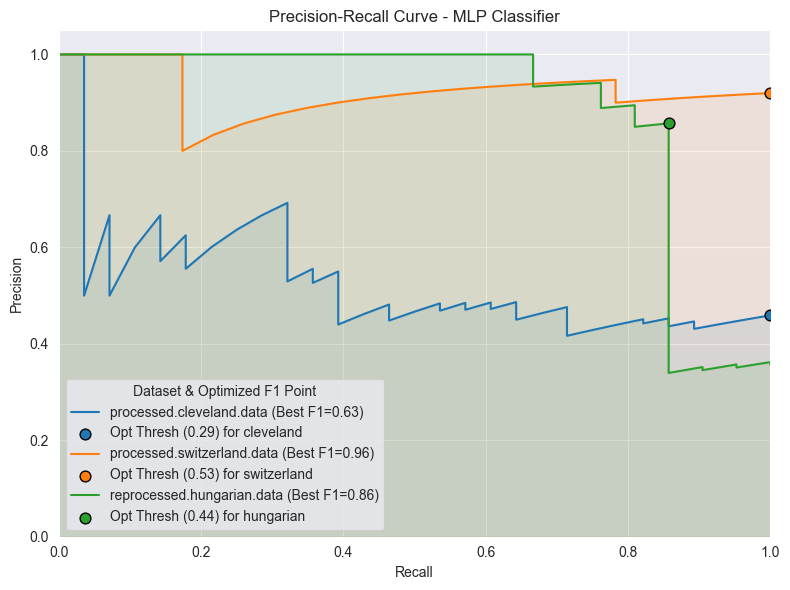

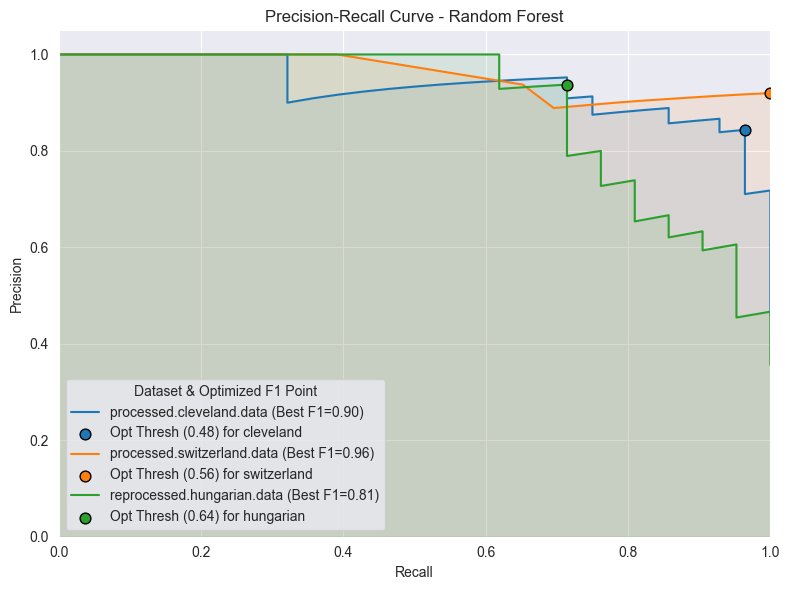

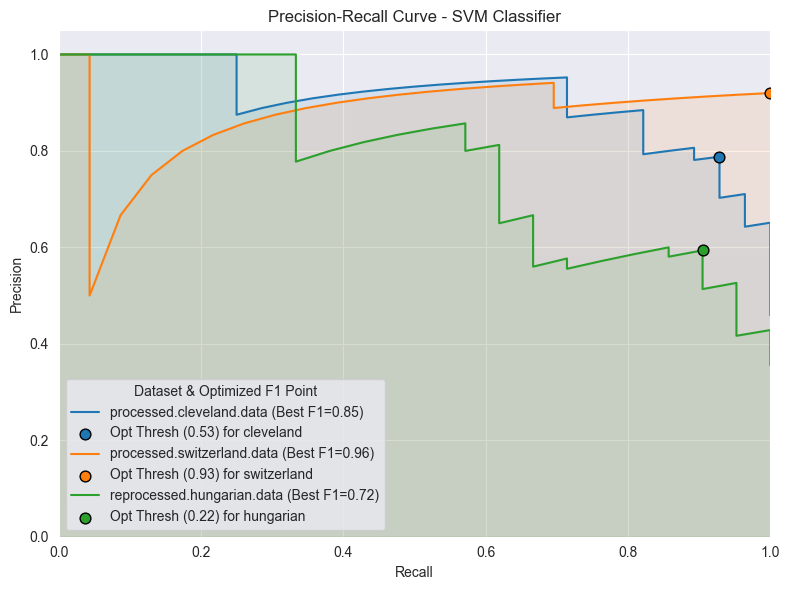

In [38]:
palette = sns.color_palette("tab10")
for model_name_pr in models_for_focused_plots:
    plt.figure(figsize=(8, 6))
    model_specific_results_focused_pr = [
        res for res in detailed_classic_results if res["Model"] == model_name_pr
    ]
    if not model_specific_results_focused_pr:
        print(f"No 'Threshold Optimization' results found for model: {model_name_pr} to plot P-R curve.")
        plt.close() 
        continue
    for i, res in enumerate(model_specific_results_focused_pr):
        dataset_name_pr = res["Dataset"]
        precisions = res["precisions_pr"]
        recalls = res["recalls_pr"]
        current_f1 = res["F1-Score (Class 1, Opt Thresh)"]
        f1_options = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        if len(f1_options) > len(res.get("thresholds_pr", recalls[:-1])):
            best_idx_pr = np.argmax(f1_options[:-1])
        else:
            best_idx_pr = np.argmax(f1_options)
        plt.plot(recalls, precisions, label=f'{dataset_name_pr} (Best F1={current_f1:.2f})',
                 color=palette[i % len(palette)])
        plt.scatter(recalls[best_idx_pr], precisions[best_idx_pr], 
                    color=palette[i % len(palette)], edgecolor='black', zorder=5, s=60, 
                    label=f'Opt Thresh ({res["Optimized Threshold"]:.2f}) for {dataset_name_pr.split(".")[1]}')
        plt.fill_between(recalls, precisions, alpha=0.1, color=palette[i % len(palette)])
    plt.title(f"Precision-Recall Curve - {model_name_pr}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(True)
    plt.legend(title="Dataset & Optimized F1 Point", loc="lower left")
    plt.tight_layout()
    plt.show()

#### 7.2.3. F1-Score Comparison Bar Plots (Focused Comparison)

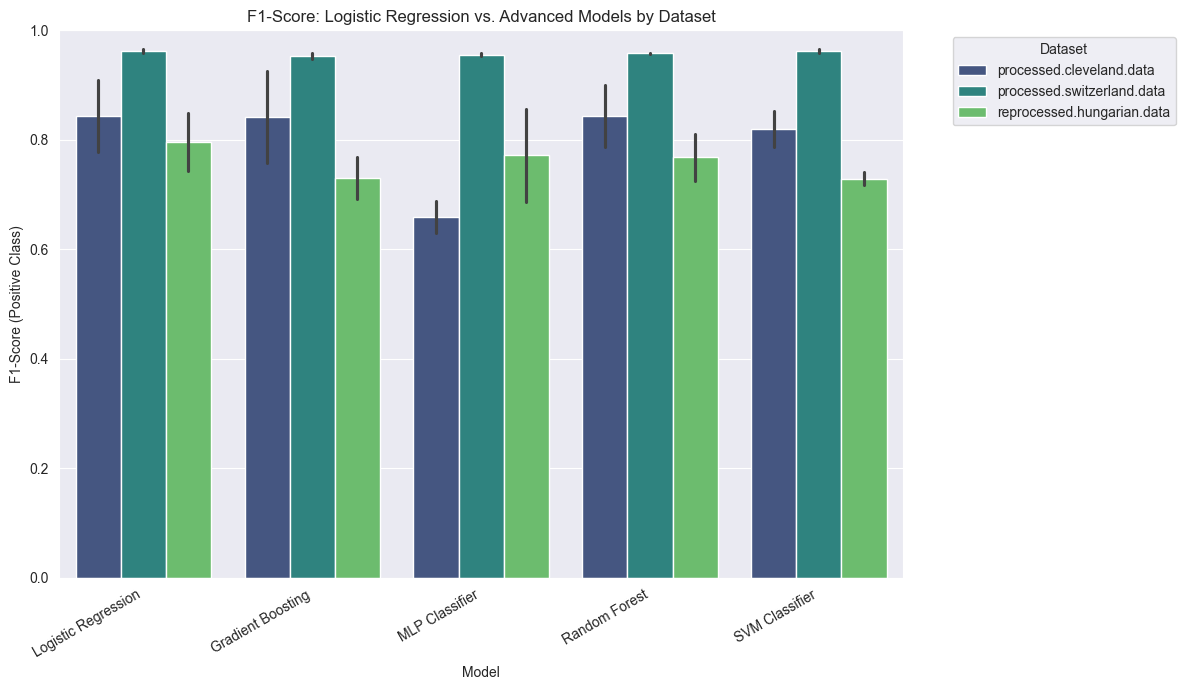

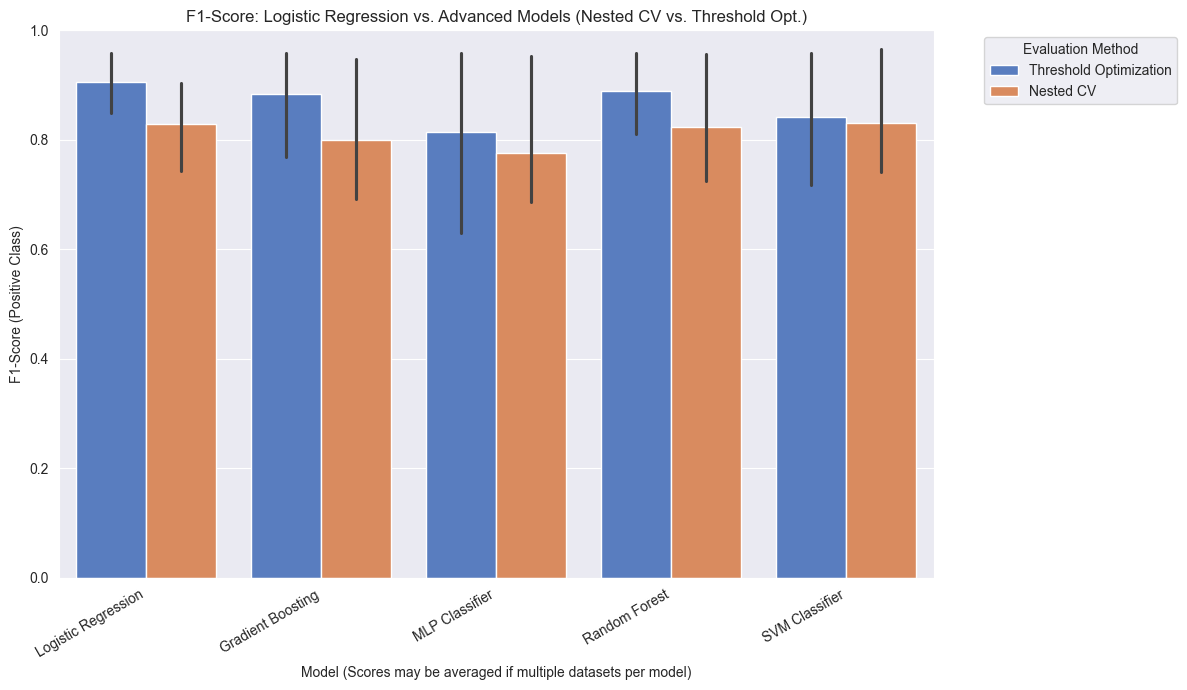

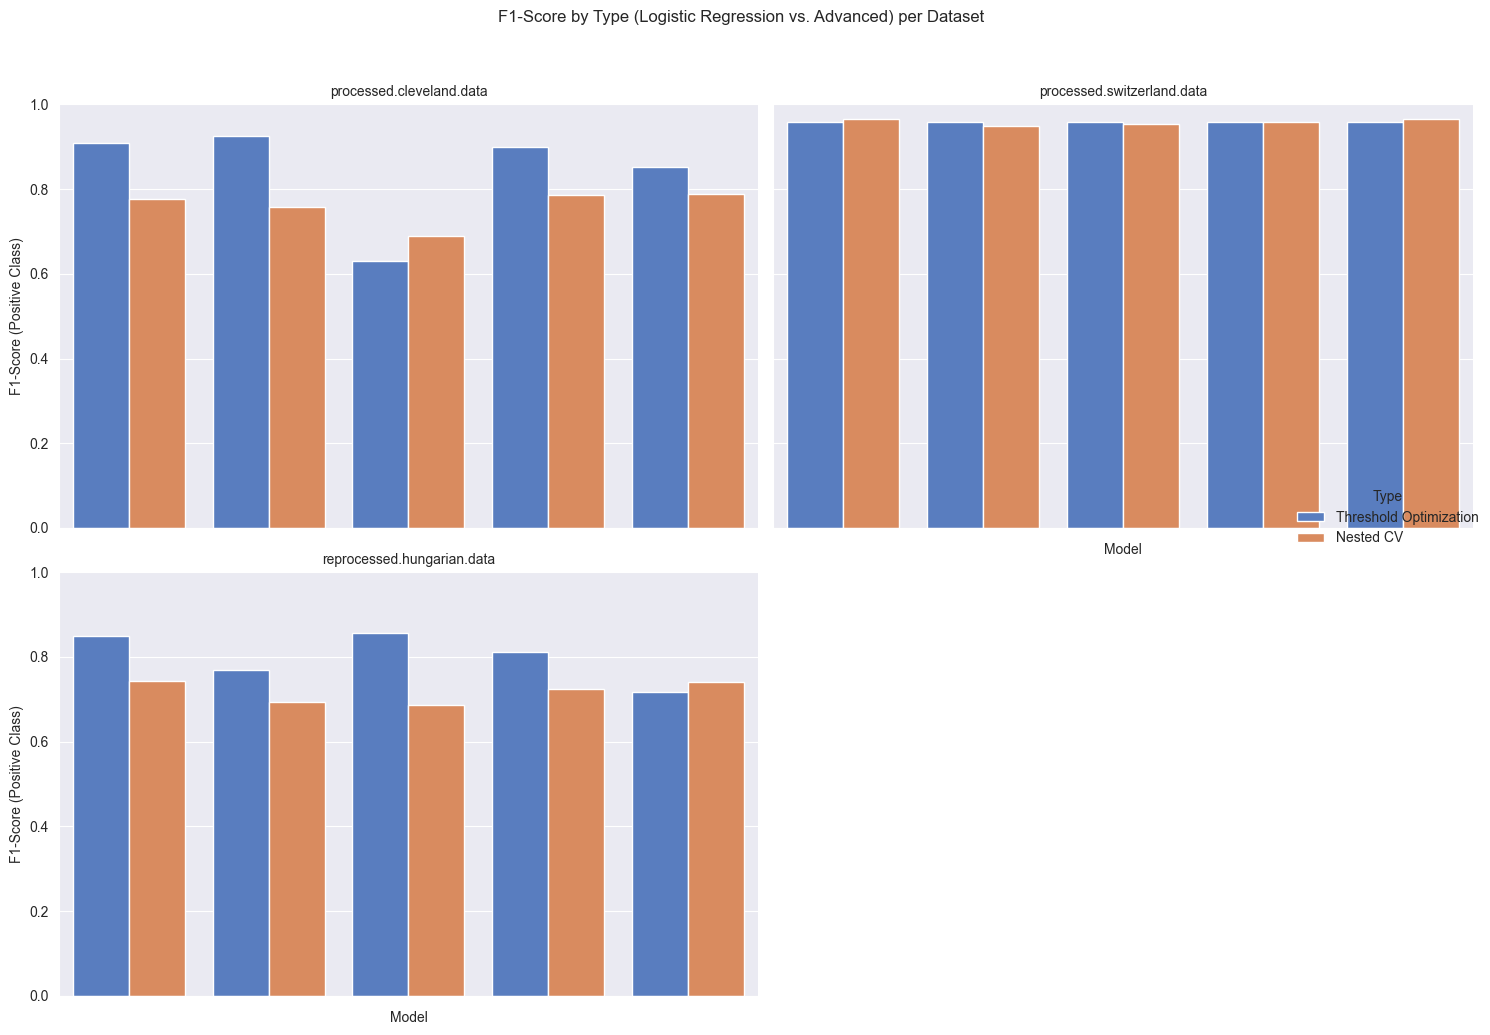

In [39]:
focused_comparison_plot_df = combined_f1_df_for_comparison[
    combined_f1_df_for_comparison['Model'].isin(models_for_focused_plots)
]

if not focused_comparison_plot_df.empty:
    title_str_dataset_hue = f"F1-Score by Dataset"
    title_str_type_hue = f"F1-Score by Eval Type"
    title_str_catplot = f"F1-Score by Type per Dataset"
    if overall_best_baseline_name:
        title_str_dataset_hue = f"F1-Score: {overall_best_baseline_name} vs. Advanced Models by Dataset"
        title_str_type_hue = f"F1-Score: {overall_best_baseline_name} vs. Advanced Models (Nested CV vs. Threshold Opt.)"
        title_str_catplot = f"F1-Score by Type ({overall_best_baseline_name} vs. Advanced) per Dataset"
    
    plt.figure(figsize=(12, 7)) 
    sns.barplot(data=focused_comparison_plot_df, x="Model", y="F1-Score", hue="Dataset", palette="viridis")
    plt.title(title_str_dataset_hue) 
    plt.ylabel("F1-Score (Positive Class)")
    plt.xlabel("Model")
    plt.ylim(0, 1)
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 7))
    sns.barplot(data=focused_comparison_plot_df, x="Model", y="F1-Score", hue="Type", palette="muted")
    plt.title(title_str_type_hue) 
    plt.ylabel("F1-Score (Positive Class)")
    plt.xlabel("Model (Scores may be averaged if multiple datasets per model)")
    plt.ylim(0, 1)
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="Evaluation Method", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    g = sns.catplot(data=focused_comparison_plot_df, x="Model", y="F1-Score", hue="Type", col="Dataset", 
                    kind="bar", palette="muted", col_wrap=2, height=5, aspect=1.3)
    g.set_titles("{col_name}")
    g.set_axis_labels("Model", "F1-Score (Positive Class)")
    g.set(ylim=(0,1))
    g.set_xticklabels(rotation=45, ha="right")
    plt.suptitle(title_str_catplot, y=1.03) 
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot for focused F1-score comparison. Check model names and filtering.")